In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, StandardScaler, OrdinalEncoder
import pickle
warnings.filterwarnings('ignore')


In [22]:
data = pd.read_csv('./ObesityDataSet2.csv')
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,24,1.58,65.29,yes,no,2.03,2.74,Sometimes,no,2.00,no,1.28,1.019,no,Public_Transportation,Overweight_Level_II
1,Male,23,1.65,66.00,no,no,3.00,3.00,Sometimes,no,2.00,no,3.00,0.000,no,Public_Transportation,Normal_Weight
2,Female,21,1.69,51.26,yes,yes,3.00,3.18,Frequently,no,1.91,no,0.48,0.625,no,Public_Transportation,Insufficient_Weight
3,Female,22,1.69,65.00,yes,yes,2.00,3.00,Sometimes,no,2.00,no,1.00,1.000,Sometimes,Public_Transportation,Normal_Weight
4,Female,23,1.61,82.64,yes,yes,2.96,1.00,Sometimes,no,2.98,no,0.74,2.000,Sometimes,Public_Transportation,Obesity_Type_I


Untuk mendapatkan info data type dari setiap kolom

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1056 non-null   object 
 1   Age                             1056 non-null   object 
 2   Height                          1056 non-null   float64
 3   Weight                          1056 non-null   float64
 4   family_history_with_overweight  1056 non-null   object 
 5   FAVC                            1056 non-null   object 
 6   FCVC                            1019 non-null   float64
 7   NCP                             1056 non-null   float64
 8   CAEC                            1056 non-null   object 
 9   SMOKE                           1056 non-null   object 
 10  CH2O                            1056 non-null   float64
 11  SCC                             1056 non-null   object 
 12  FAF                             10

Dataset Description

a. Gender = Laki-laki atau Wanita

b. Age = Usia seseorang dalam tahun

c. Height = Tinggi dalam meter

d. Weight = Berat dalam kilogram

e. family_history_with_overweight = Apakah orang tersebut memiliki riwayat keluarga dengan kelebihan berat badan

f. FAVC = Jika orang tersebut sering mengonsumsi makanan berkalori tinggi (ya/tidak)

g. FCVC = Frekuensi konsumsi sayuran (skala dari 1 hingga 3)

h. NCP = Jumlah makanan utama per hari

i. CAEC = Frekuensi mengonsumsi makanan di antara waktu makan (Tidak pernah, Kadang-kadang, Sering, Selalu)

j. SMOKE = Apakah orang tersebut merokok (ya/tidak)

k. CH2O = Asupan air harian (skala dari 1 hingga 3)

l. SCC = Jika orang tersebut memantau asupan kalori mereka (ya/tidak)

m. FAF = Frekuensi aktivitas fisik (skala dari 0 hingga 3)

n. TUE = Waktu yang dihabiskan untuk menggunakan teknologi (skala dari 0 hingga 3)

o. CALC = Frekuensi konsumsi alkohol (Tidak pernah, Kadang-kadang, Sering, Selalu)

p. MTRANS = Moda transportasi utama (Mobil, Sepeda, Sepeda Motor, Transportasi Umum, Jalan Kaki)

q. NObeyesedad = Tingkat obesitas (Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, Obesity Type III)


# Data Cleaning

In [24]:
print ("Missing Values : ")
null_count = data.isnull().sum()
null_percentage = (null_count / len(data)) * 100

null_summary = pd.DataFrame({
    'Jumlah Null': null_count,
    'Persen (%)': null_percentage.round(2)
})

print(null_summary)
print ("------------------------------")
print ("Duplicate Values : " + str(data.duplicated().sum()))
print ("------------------------------")

Missing Values : 
                                Jumlah Null  Persen (%)
Gender                                    0        0.00
Age                                       0        0.00
Height                                    0        0.00
Weight                                    0        0.00
family_history_with_overweight            0        0.00
FAVC                                      0        0.00
FCVC                                     37        3.50
NCP                                       0        0.00
CAEC                                      0        0.00
SMOKE                                     0        0.00
CH2O                                      0        0.00
SCC                                       0        0.00
FAF                                       0        0.00
TUE                                       0        0.00
CALC                                      0        0.00
MTRANS                                   26        2.46
NObeyesdad                    

In [25]:
print("Data Anomaly")
print ("------------------------------")
for column in data.columns:
    print(f"{column} : {data[column].unique()[:50]}")
print ("------------------------------")


Data Anomaly
------------------------------
Gender : ['Female' 'Male']
Age : ['24' '23' '21' '22' '26' '18' '25' '20' '32' '20 years' '19' '38' '34'
 '44' '39' '22 years' '41' '31' '17 years' '17' '29' '42' '27' '16'
 '25 years' '40' '21 years' '33' '30' '37' '35' '36' '15' '19 years' '28'
 '55' '46' '36 years' '26 years' '45' '33 years' '43' '51' '48' '23 years'
 '14']
Height : [1.58 1.65 1.69 1.61 1.68 1.62 1.74 1.66 1.85 1.75 1.76 1.83 1.81 1.57
 1.63 1.6  1.78 1.84 1.72 1.77 1.8  1.71 1.5  1.64 1.7  1.87 1.88 1.91
 1.82 1.9  1.59 1.67 1.79 1.54 1.73 1.53 1.89 1.55 1.56 1.52 1.51 1.93
 1.86 1.95 1.92 1.45 1.49]
Weight : [ 65.29  66.    51.26  65.    82.64 104.85  49.95  55.    82.6   50.
  68.    85.23  76.7   74.    87.91 105.01 152.72  85.32  44.32  58.
  42.85  77.93 106.88 133.67  89.67  80.    65.42 115.    48.    60.
  62.    89.28 152.22 108.25 121.86  91.8   90.    77.35  68.65  53.
  86.93  69.46 121.74  95.    70.    79.49  82.01 111.72 106.33 121.53]
family_history_with_o

# Missing Value
Disini terdapat missing value untuk : 
- FCVC : 37 (3.5%)
- MTRANS : 26 (2.46%)
Disini saya akan mengimpute dengan mean / median / modus.

- MTRANS adalah kategorikal jadi kita impute dengan modus 
- FCVC adalah numeric  jadi kita impute dengan mean / median.

untuk menentukan mean / median kt harus melihat distribusi dari tiap kolom dlu.
- Jika distribusi normal : pakai mean
- Jika distribusi tidak normal : pakai median

# Anomaly Data
Anomaly data dapat terlihat pada Age dimana terlihat didalam datanya tidak hany ada numeric tetapi ada format seperti %d years, jadi disini kita harus menyamakan semuanya dengan cara hilangkan ' years' dan convert ke int

# Duplicate Data
Untuk Duplicate Data akan kita drop datanya.

In [26]:
# Drop Duplicate Data
data = data.drop_duplicates()
data['Age'] = data['Age'].astype(str).str.extract('(\d+)').astype(int)


In [27]:
FEAT_IMPORTANCE = True
if FEAT_IMPORTANCE:
    data= data.drop(columns=["MTRANS","SMOKE"])

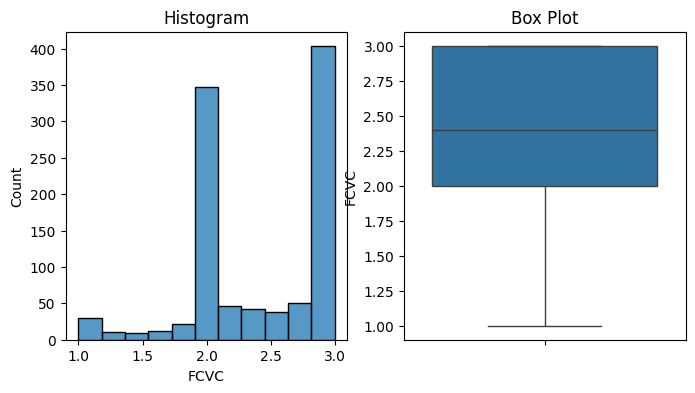

FCVC
Skewness :  -0.45405649350377836
Kurtosis :  -0.6350682799200609


In [28]:
def check_distribution(data,columns):
  for column in columns:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    sns.histplot(data[column])
    plt.title('Histogram')

    plt.subplot(1,2,2)
    sns.boxplot(data[column])
    plt.title('Box Plot')
    plt.show()
    print(column)
    print("Skewness : ", data[column].skew())
    print("Kurtosis : ", data[column].kurt())

check_distribution(data,["FCVC"])

Skewness menunjukkan sejauh mana distribusi data tidak simetris.
- Jika skewness mendekati 0 (-0.5 - 0.5), distribusi cenderung simetris (normal).
- Jika skewness lebih besar dari 0.5, distribusi miring ke kanan (positif skew)
- Jika skewness lebih kecil dari -0.5, distribusi miring ke kiri (negatif skew)

Kurtosis menunjukkan sejauh mana distribusi memiliki puncak yang tajam atau datar dibandingkan distribusi normal.
- Kurtosis normal adalah sekitar -3 sampai 3
- Jika kurtosis lebih besar dari 3, distribusi lebih tajam
- Jika kurtosis lebih kecil dari -3, distribusi lebih datar

Kalau salah satu menunjukkan tidak normal , maka distribusi tersebut tidak normal.

Disini kita bisa lihat kalaua distribusinya itu normal
Berdasarkan skewness > -0.5 dan kurtosis < 3-> ini juga menunjukkna distribusinormal.
Jadi kita impute dengan mean

Sebelum kita melakukan imputasi , kita akan split data menjadi train: test (80:20) karena kita akan mengambl mean dan modus dari train data saja kemudian mengimpute null value

In [29]:
x = data.drop(columns=["NObeyesdad"])
y = data["NObeyesdad"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [30]:
FCVC_imputation = x_train["FCVC"].mean()
x_train['FCVC'] = x_train['FCVC'].fillna(FCVC_imputation)
x_test['FCVC'] = x_test['FCVC'].fillna(FCVC_imputation)
if FEAT_IMPORTANCE == False:
    MTRANS_imputation = x_train["MTRANS"].mode()[0]
    x_train['MTRANS'] = x_train['MTRANS'].fillna(MTRANS_imputation)
    x_test['MTRANS'] = x_test['MTRANS'].fillna(MTRANS_imputation)

# EDA

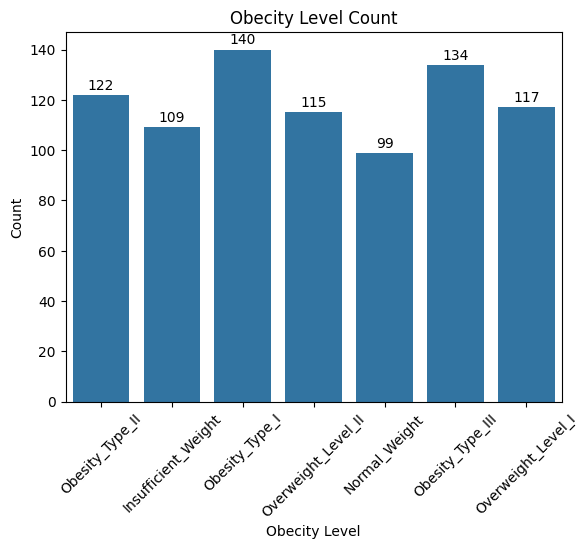

In [31]:
ax = sns.countplot(x='NObeyesdad', data=pd.DataFrame(y_train, columns=['NObeyesdad']))
plt.title('Obecity Level Count')
plt.xlabel('Obecity Level')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,   
        height + 1,                      
        f'{int(height)}',
        ha='center', va='bottom'
    )
plt.xticks(rotation=45)
plt.show()

Dari plot diatas, kita dapat melihat jumlah datanya cukup setara atau seimbang.

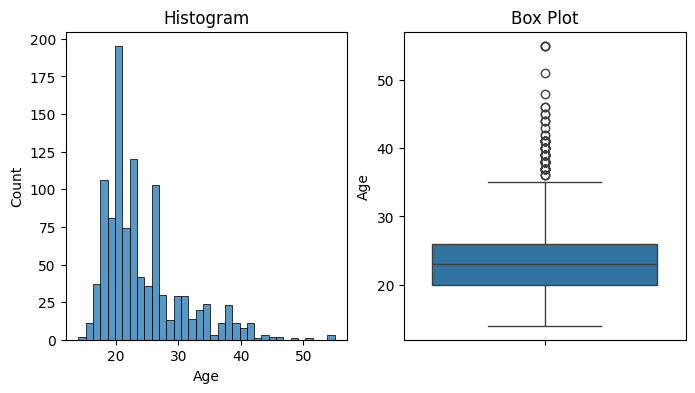

Age
Skewness :  1.4476239806674693
Kurtosis :  2.316809563284867


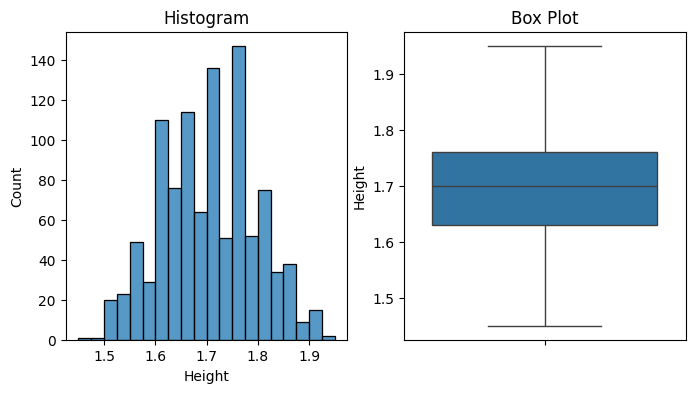

Height
Skewness :  0.03604672579381315
Kurtosis :  -0.538891811629286


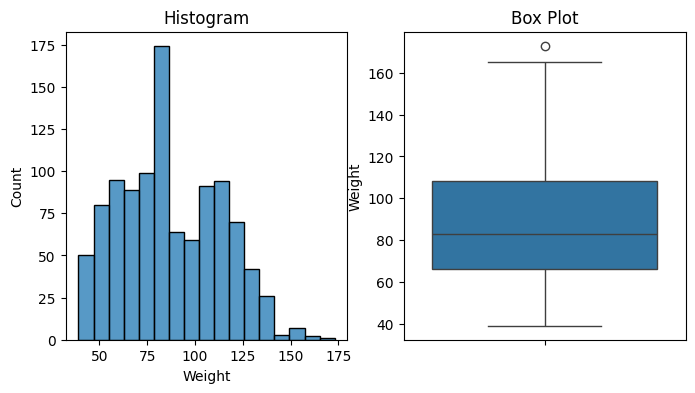

Weight
Skewness :  0.2608974120652147
Kurtosis :  -0.6689610859451927


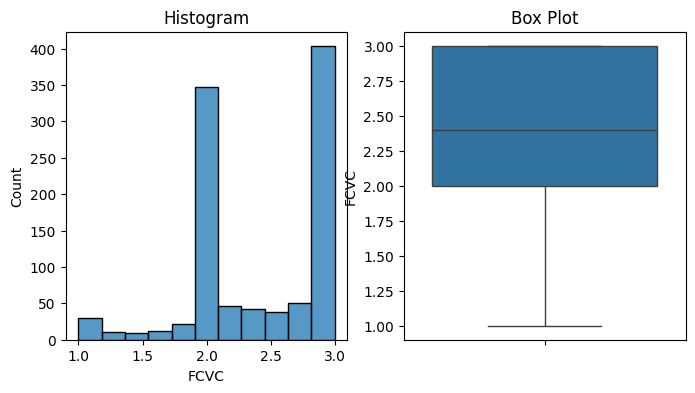

FCVC
Skewness :  -0.45405649350377836
Kurtosis :  -0.6350682799200609


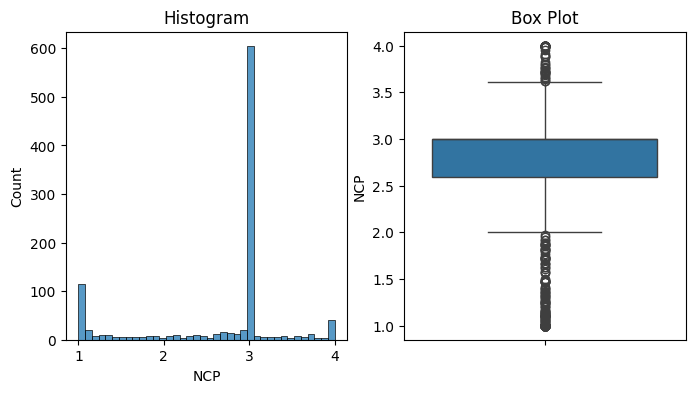

NCP
Skewness :  -1.052522897993634
Kurtosis :  0.16496007293392623


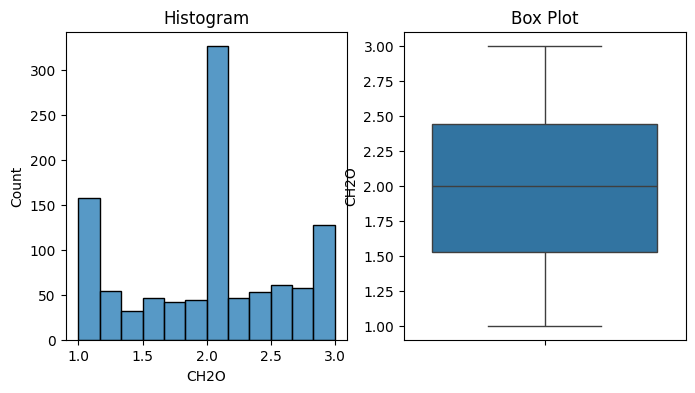

CH2O
Skewness :  -0.08511331693843992
Kurtosis :  -0.8686438491924702


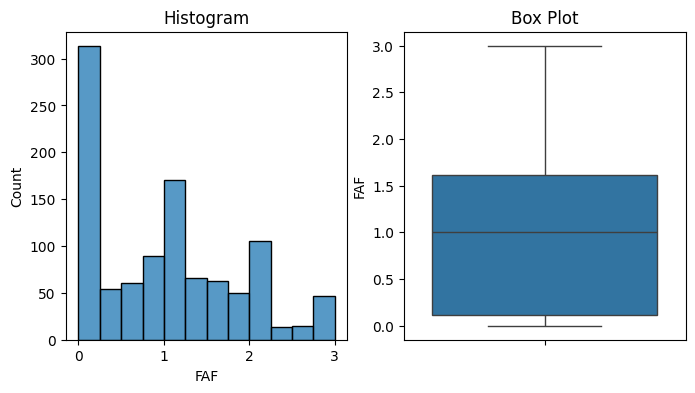

FAF
Skewness :  0.5467263018358227
Kurtosis :  -0.5708862552222849


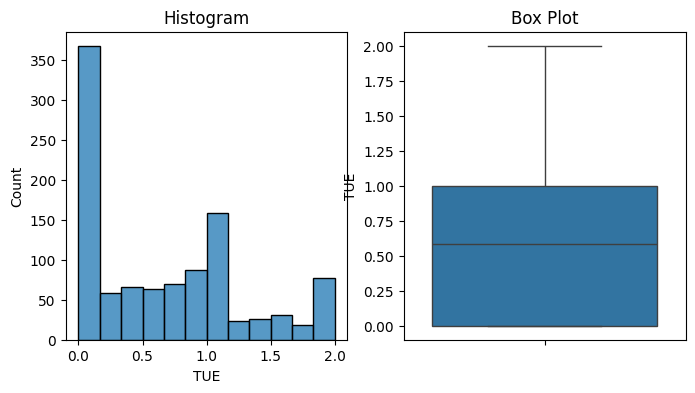

TUE
Skewness :  0.6563595085297159
Kurtosis :  -0.5391792565637301


In [32]:
num_cols = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
check_distribution(data,num_cols)


# Encoding

Dapat dilihat bahwa semua datanya itu distribusinya normal berdasakran plot, skewness dan kurtosisnya kecuali NCP.

Oleh karena itu, kita memakai standard scaler untuk yang distribusinya normal, sedangkan robust scaler karena scaler ini dapat kurangi pengaruh outlier karena dia skalain data by median dan IQR.

In [33]:
normal_cols = ['Age','Height','Weight','FCVC','CH2O','FAF','TUE']
unnormal_cols = ['NCP']
rob_scaler = RobustScaler()
std_scaler = StandardScaler()
x_train[normal_cols] = std_scaler.fit_transform(x_train[normal_cols])
x_train[unnormal_cols] = rob_scaler.fit_transform(x_train[unnormal_cols])
x_test[normal_cols] = std_scaler.transform(x_test[normal_cols])
x_test[unnormal_cols] = rob_scaler.transform(x_test[unnormal_cols])

In [34]:
ohe_encoders = {}
def one_hot_encode_column(train_df, test_df, column):
    ohe_encoders[column] = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    train_encoded = ohe_encoders[column].fit_transform(train_df[[column]])
    test_encoded = ohe_encoders[column].transform(test_df[[column]])

    col_names = [f'{column}_{cat}' for cat in ohe_encoders[column].categories_[0]]

    train_ohe_df = pd.DataFrame(train_encoded, columns=col_names, index=train_df.index)
    test_ohe_df = pd.DataFrame(test_encoded, columns=col_names, index=test_df.index)

    train_df = pd.concat([train_df.drop(columns=[column]), train_ohe_df], axis=1)
    test_df = pd.concat([test_df.drop(columns=[column]), test_ohe_df], axis=1)

    return train_df, test_df


ohe_columns = ['CAEC','CALC'] 
ohe_columns += ['MTRANS'] if FEAT_IMPORTANCE == False else []

for col in ohe_columns:
    x_train, x_test = one_hot_encode_column(x_train, x_test, col)


In [35]:
label_encoders = {}
def label_encode(train_df,test_df,column):
    label_encoders[column] = LabelEncoder()

    train_df[column] = label_encoders[column] .fit_transform(train_df[column])
    test_df[column] = label_encoders[column] .transform(test_df[column])
    return train_df,test_df

le_columns = ['Gender','FAVC','family_history_with_overweight','SCC'] 
le_columns += ['SMOKE'] if FEAT_IMPORTANCE == False else []

for col in le_columns:
    x_train, x_test = label_encode(x_train, x_test, col)
    
y_encoder = LabelEncoder()
y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [36]:
x_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CH2O,SCC,FAF,TUE,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Frequently,CALC_Sometimes,CALC_no
258,1,-0.070877,-1.013435,0.491154,1,1,0.857273,-3.076923,-1.617226,0,0.104070,0.671748,0.0,0.0,1.0,0.0,0.0,0.0,1.0
355,0,-0.383556,0.079767,-1.349945,1,1,0.857273,0.000000,-1.584321,0,1.428859,1.179293,0.0,1.0,0.0,0.0,0.0,0.0,1.0
60,1,-0.539896,1.938210,1.147818,1,1,-0.796833,-1.940828,0.554478,0,-0.118682,0.937529,0.0,0.0,1.0,0.0,0.0,1.0,0.0
348,1,-1.008916,0.626368,-0.088479,1,1,0.800883,0.000000,1.459354,0,0.010279,-0.335336,0.0,0.0,1.0,0.0,0.0,1.0,0.0
385,0,-0.383556,-1.232075,-1.653490,0,0,1.082832,-3.289941,0.949333,0,0.233032,-1.022203,0.0,1.0,0.0,0.0,0.0,0.0,1.0


n_estimator = jumlah tree.

num_leave = jumlah max leave dari tree.

iteration = sama dengan n_estimator -> jumlah tree.

max_depth = kedalaman max dari decision tree

learning_rate = sbrp besar kontribusi tree terhadap prediksi akhir

In [17]:
if FEAT_IMPORTANCE == False:
    models = {
        "LightGBM": LGBMClassifier(random_state=42,verbose=-1),
        "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
    }

    model_param = {
        "LightGBM": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [15, 31, 63]
        },
        "CatBoost": {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1],
            'depth': [4, 6, 8]
        }
    }

    model_scores = {}
    trained_models = {}
    param_models = {}
    for model_name, model in models.items():
        grid_search = GridSearchCV(estimator=model, param_grid=model_param[model_name], cv=5, scoring="accuracy")
        grid_search.fit(x_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        trained_models[model_name] = best_model
        param_models[model_name] = best_params

        y_pred = best_model.predict(x_test)

        print(f"\nBest Model for {model_name}:")
        print("----------------------- Model -----------------------")
        print(best_model)
        print("-----------------------------------------------------")
        print(f"Best Parameters: {best_params}")

        report = classification_report(y_test, y_pred, output_dict=True)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        accuracy = report['accuracy']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        model_scores[model_name] = accuracy
        

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro Precision: {precision:.4f}")
        print(f"Macro Recall: {recall:.4f}")
        print(f"Macro F1-score: {f1:.4f}")



    best_model_name = max(model_scores, key=model_scores.get)
    best_model = trained_models[best_model_name]
    print(f"\nBest Model Overall: {best_model_name} with an acuracy of {model_scores[best_model_name]:.4f} and param {param_models[best_model_name]}")



Best Model for LightGBM:
----------------------- Model -----------------------
LGBMClassifier(n_estimators=200, random_state=42, verbose=-1)
-----------------------------------------------------
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.93      0.95      0.94        41
           2       0.85      0.97      0.91        36
           3       1.00      0.96      0.98        27
           4       1.00      1.00      1.00        28
           5       0.85      0.77      0.81        22
           6       0.89      0.83      0.86        30

    accuracy                           0.93       210
   macro avg       0.93      0.92      0.93       210
weighted avg       0.93      0.93      0.93       210

Accuracy: 0.9286
Macro Precision: 0.9322
Macro Recall: 0.9220
Macro F1-score: 0.9260

Best Model for Cat

In [37]:
if FEAT_IMPORTANCE == True:
    models = {
        "LightGBM": LGBMClassifier(random_state=42,verbose=-1),
        "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
    }

    model_param = {
        "LightGBM": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [15, 31, 63]
        },
        "CatBoost": {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1],
            'depth': [4, 6, 8]
        }
    }

    model_scores = {}
    trained_models = {}
    param_models = {}
    for model_name, model in models.items():
        grid_search = GridSearchCV(estimator=model, param_grid=model_param[model_name], cv=5, scoring="accuracy")
        grid_search.fit(x_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        trained_models[model_name] = best_model
        param_models[model_name] = best_params

        y_pred = best_model.predict(x_test)

        print(f"\nBest Model for {model_name}:")
        print("----------------------- Model -----------------------")
        print(best_model)
        print("-----------------------------------------------------")
        print(f"Best Parameters: {best_params}")

        report = classification_report(y_test, y_pred, output_dict=True)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        accuracy = report['accuracy']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        model_scores[model_name] = accuracy
        

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro Precision: {precision:.4f}")
        print(f"Macro Recall: {recall:.4f}")
        print(f"Macro F1-score: {f1:.4f}")



    best_model_name = max(model_scores, key=model_scores.get)
    best_model = trained_models[best_model_name]
    print(f"\nBest Model Overall: {best_model_name} with an acuracy of {model_scores[best_model_name]:.4f} and param {param_models[best_model_name]}")



Best Model for LightGBM:
----------------------- Model -----------------------
LGBMClassifier(n_estimators=200, num_leaves=15, random_state=42, verbose=-1)
-----------------------------------------------------
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 15}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.95      0.95      0.95        41
           2       0.88      0.97      0.92        36
           3       1.00      0.96      0.98        27
           4       1.00      1.00      1.00        28
           5       0.86      0.86      0.86        22
           6       0.89      0.83      0.86        30

    accuracy                           0.94       210
   macro avg       0.94      0.93      0.94       210
weighted avg       0.94      0.94      0.94       210

Accuracy: 0.9381
Macro Precision: 0.9404
Macro Recall: 0.9350
Macro F1-score: 0.9371

Bes

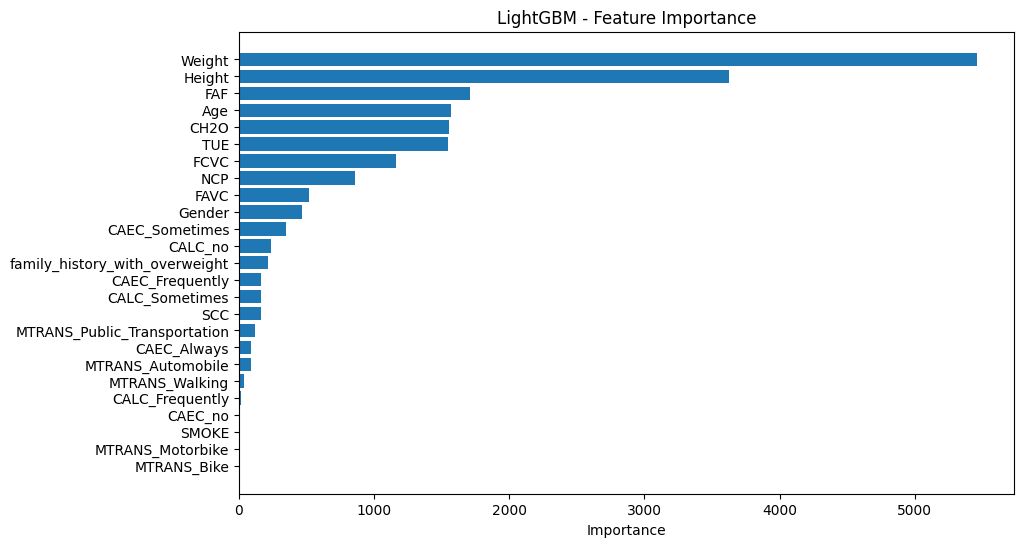

In [19]:
if FEAT_IMPORTANCE == False:
    importances = best_model.feature_importances_
    features = x_train.columns
    feat_importance = pd.DataFrame({'Fitur': features, 'Importance': importances})
    feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feat_importance['Fitur'], feat_importance['Importance'])
    plt.xlabel('Importance')
    plt.title(f'{best_model_name} - Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

Disini kita menggunakan accuracy karna datanya balance dan juga secara evaluasi memiliki hasil metric yang tidak jauh berbeda yang artinya modelnya cukup bagus untuk memprediksi tingkat obesitas. Nah disini kita mendaatkan model terbaiknya adalah lightbgm dengan accuracy 0.9381 dan param {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 15}

In [20]:
model_data = {
    'model': best_model,
    'std_scaler': std_scaler,
    'rob_scaler': rob_scaler,
    'label_encoders': label_encoders,
    'ohe_encoders': ohe_encoders,
    'y_encoder' : y_encoder,
    'normal_cols' : normal_cols,
    'unnormal_cols' : unnormal_cols,
    'ohe_columns' : ohe_columns,
    'le_columns' : le_columns,
    'all_columns' : x_train.columns
}
        
with open('model_without_cloud.pkl', 'wb') as f:
    pickle.dump(model_data, f)